In [1]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['figure.figsize'] = (12,12)
from skimage import io

In [2]:
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import models
from tensorflow.python.keras import losses

//anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
//anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


To do: 
1. pair predictions back to their original images.
2. consider network to detect traps for cropping of traps.


# Read 2048x2048 images, tile them in generator
## Set up image generator

We need to pull images from a given directory, and crop them to 256x256 sub-images.

The `tileImage` function will do the cropping and arrange the sub-images into a tidy numpy array. `crop_generator` will accept a batch of images, and call `tileImage` on each image in the batch.

In [3]:
def tileImage(img, subImageNumber):
    divisor = int(np.sqrt(subImageNumber))
    M = img.shape[0]//divisor
    N = img.shape[0]//divisor
    tiles = np.asarray([img[x:x+M,y:y+N] for x in range(0,img.shape[0],M) for y in range(0,img.shape[1],N)])
    return(tiles)

def crop_generator(batches, subImageNumber=64):
    while True:
        batch_imgs = next(batches)
        x_subImageNumber = int(np.sqrt(subImageNumber))
        crop_length = int(batch_imgs.shape[1]//x_subImageNumber)
        batch_tiles = np.zeros((batch_imgs.shape[0]*subImageNumber, crop_length, crop_length, 1)) # array to store batch of tiled images
        for i in range(batch_imgs.shape[0]):  # loop through all images in the batch
            tile = tileImage(batch_imgs[i], subImageNumber=subImageNumber)
            batch_tiles[i*tile.shape[0]:i*tile.shape[0]+tile.shape[0],...] = tile # toss the tiles image into its appropriate batch
        yield (batch_tiles)

Don't augment the images, since this is a prediction task, and not a training task. No augmentation is the default behavior of the `ImageDataGenerator` class, so no need to define any arguments here.

In [4]:
image_datagen = ImageDataGenerator()

## Make the image generator

### NOTE:
I had to modify the source code for tensorflow to get 16-bit images to read in correctly. My problem was that the pixel intensity values of all my 16-bit images, after reading in, were truncated to 255! 

Following the suggestion by jfx319 [here](https://github.com/keras-team/keras/issues/4486), I modified tensorflow's image.py code in `load_img` from:

```python
if grayscale:
    if img.mode != 'L':
        img = img.convert('L')
```

to now be:

```python
if grayscale:
    img = img.convert('I')
```

That seems to be a fine fix.

If you're not sure where to find tensorflow's image.py, I recommend running the following from your command line:

```bash
locate image.py | grep tensorflow
```

In [14]:
seed = 1
batch_size=1 # Here, batch_size refers to the number of 2048x2048 images read in by the generator at once.
             # Each image is cropped to 64 256x256 pixel sub-images.
             # This means that a batch_size of 2 large images here translates to a batch_size of 2*64 sub-images when the generator is actually run
subImageNumber = 64 # how many cropped sub-images to make from each large image

#'/Volumes/GoogleDrive/My Drive/code_20180913/motherMachineSegger/full_image_data/test/images'

image_generator = image_datagen.flow_from_directory( # will take images from a directory
    './shift35_imgs/test/images/', # the images are actually in 'full_image_data/test/images/cells' because flow_from_directory requires your images to be in sub-directories, assuming you have different classes of images in different sub-directories
    color_mode="grayscale",
    class_mode=None,
    seed=seed,
    batch_size=batch_size,
    target_size=(2048,2048)) # defaults to (256,256), so make sure you define the full image size.

test_crops = crop_generator(image_generator, subImageNumber=subImageNumber)

Found 1 images belonging to 1 classes.


## Define functions for loss metrics

This is ripped straight off of this [tutorial](https://github.com/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb), in the **Defining custom metrics and loss functions** section.

In [6]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

## Read in the model that was saved when we ran train_Unet.ipynb

Save time by checking if `model` is defined before deciding whether to read it in.

In [7]:
try: 
    model
except:
    model = models.load_model('weights_20181009_e20.hdf5', custom_objects={'bce_dice_loss': bce_dice_loss,
                                                           'dice_loss': dice_loss})

In [8]:
def imageConcatenator(imgStack, subImageNumber = 64):
    
    rowNumPerImage = int(np.sqrt(subImageNumber)) # here I'm assuming our large images are square, with equal number of crops in each dimension
    imageNum = int(imgStack.shape[0]/subImageNumber) # total number of sub-images divided by the number of sub-images in each original large image
    iterNum = int(imageNum*rowNumPerImage)
    imageDims = int(np.sqrt(imgStack.shape[1]*imgStack.shape[2]*subImageNumber))
    bigImg = np.zeros(shape=(imageNum, imageDims, imageDims), dtype='float32') # create array to store reconstructed images
    rowDict = {}
    
    for i in range(iterNum):
        baseNum = int(i*iterNum/imageNum)
        # concatenate columns of 256x256 images to build each 256x2048 row
        rowDict[i] = np.column_stack((imgStack[baseNum,:,:,0],imgStack[baseNum+1,:,:,0],imgStack[baseNum+2,:,:,0],imgStack[baseNum+3,:,:,0],imgStack[baseNum+4,:,:,0],imgStack[baseNum+5,:,:,0],imgStack[baseNum+6,:,:,0],imgStack[baseNum+7,:,:,0],))

    for i in range(imageNum):
        baseNum = int(i*rowNumPerImage)
        # concatenate appropriate 256x2048 rows to build a 2048x2048 image and place it into bigImg
        bigImg[i,:,:] = np.row_stack((rowDict[baseNum],rowDict[baseNum+1],rowDict[baseNum+2],rowDict[baseNum+3],rowDict[baseNum+4],rowDict[baseNum+5],rowDict[baseNum+6],rowDict[baseNum+7]))
    
    return(bigImg)

## Run model on 256x256 cropped images

Here we're cropping and feeding the images in one step by using our `test_crops` generator. The model runs on each 256x256 crop, and the resulting object is predictions for each crop from each large image in our test directory.

`model.predict_generator` will handle taking batches of images from `test_crops` and stacking up the resulting predictions in the output. Note the `steps=stepNumber` argument here. It essentially defines how many distinct batches of images we are going to run the model on. Here I've written code to allow us to just run on all the images in the directory defined in the `test_crops` image generator. You can imagine a scenario, however, where we have thousands of images, and we won't be able to fit all their predictions into RAM at once. Maybe in that case we could set up a loop to run a few steps at a time, saving the resulting predictions to disk each time through the loop.

After getting the model's predictions we reconstruct the full 2048x2048 predictions by concatenating the appropriate 256x256 crops using the `imageConcatenator` function defined above.

In [27]:
imageNumber = len(glob.glob('./shift35_imgs/test/images/cells/*.*'))
stepNumber = int(np.ceil(imageNumber/batch_size))

predictions = model.predict_generator(test_crops, steps=stepNumber)
prediction = imageConcatenator(predictions)

In [28]:
print(prediction.shape) # sanity check that the first dimention is imageNum long

(1, 2048, 2048)


## Take a look at your predictions

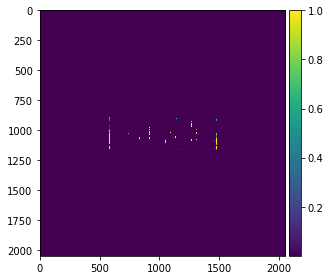

In [29]:
# prediction[prediction < 0.99] = 0 
io.imshow(prediction[0, :, :])
plt.savefig('./prediction20181009_1.png', dpi=600)

In [20]:
prediction.shape

(1, 2048, 2048)